# Combined Cycle Power Plant


The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

<i>"For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing."</i> - The data file (xlsx) has 5 sheets of the same data (shuffled).

<b>Source:</b> UCI ML Repo (https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant#)


Features consist of hourly average ambient variables
- Ambient Temperature (AT) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical power output (PE) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [68]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #with momentum
from tensorflow.keras.metrics import Accuracy

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'data/Folds5x2_pp.xlsx'
df = pd.read_excel(path, 'Sheet1')
df.head() 

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [3]:
df.tail()

,AT,V,AP,RH,PE
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74
9567,21.60,62.52,1017.23,67.87,453.28


In [4]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [5]:
df.isnull().sum() 

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [7]:
df.shape

(9568, 5)

### Visualization of Features

Visualization of features values individually.


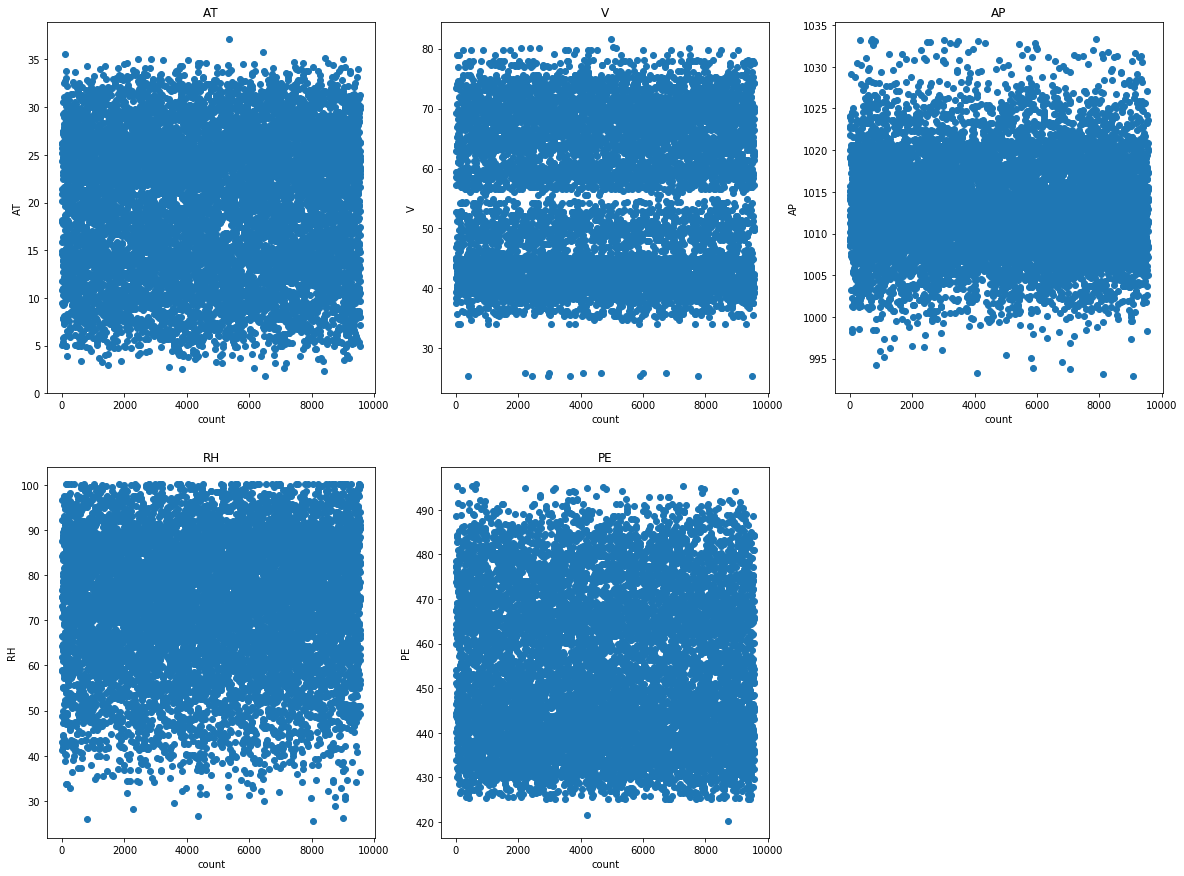

Data is not ordered according to time.


In [8]:
y1 = df.AT
y2 = df.V
y3 = df.AP
y4 = df.RH
y5 = df.PE

x = range(df.shape[0])

plt.figure(figsize=(20,15))

plt.subplot(2, 3, 1)
plt.scatter(x, y1)
plt.ylabel('AT')
plt.xlabel('count')
plt.title('AT')

plt.subplot(2, 3, 2)
plt.scatter(x, y2)
plt.ylabel('V')
plt.xlabel('count')
plt.title('V')

plt.subplot(2, 3, 3)
plt.scatter(x, y3)
plt.ylabel('AP')
plt.xlabel('count')
plt.title('AP')

plt.subplot(2, 3, 4)
plt.scatter(x, y4)
plt.ylabel('RH')
plt.xlabel('count')
plt.title('RH')

plt.subplot(2, 3, 5)
plt.scatter(x, y5)
plt.ylabel('PE')
plt.xlabel('count')
plt.title('PE')

print('Visualization of features values individually.')
plt.show()
print('Data is not ordered according to time.')

### Distribution of Data

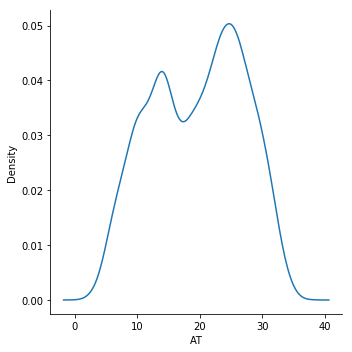

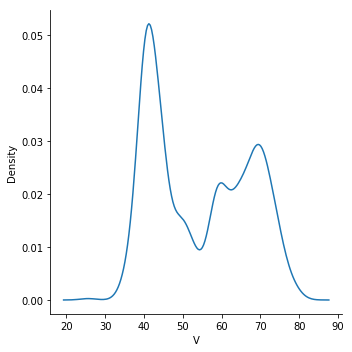

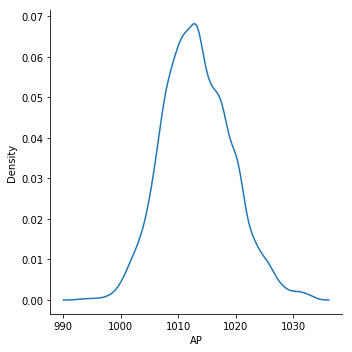

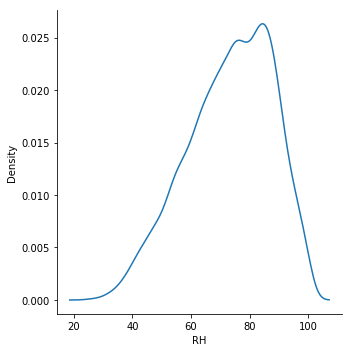

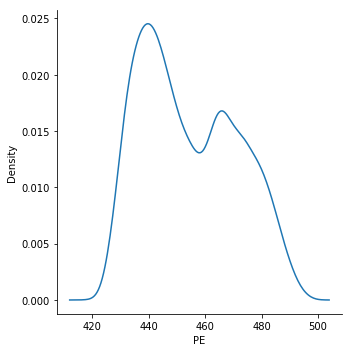

In [9]:
# kernal density estimation plots - probability density function (similar in intuition to histogram)

sns.displot(df, x="AT", kind="kde")

sns.displot(df, x="V", kind="kde")

sns.displot(df, x="AP", kind="kde")

sns.displot(df, x="RH", kind="kde")

sns.displot(df, x="PE", kind="kde")

Correlation between features.


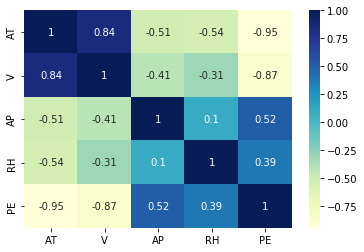

In [10]:
print('Correlation between features.')

sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

Correlation pairplot


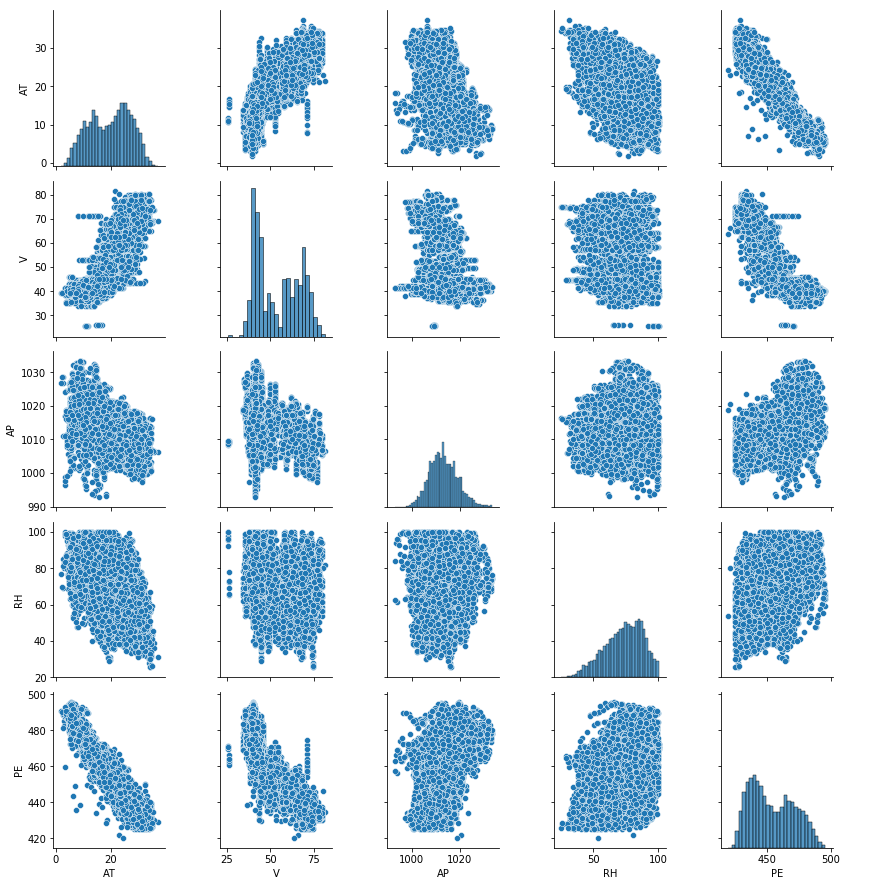

In [11]:
print('Correlation pairplot')

sns.pairplot(df)

### Train-Test Split

In [12]:
train, test = train_test_split(df,test_size=0.2,random_state=42)

### Standardizing/Scaling Values

In [13]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

train_std = scaler.fit_transform(train)
test_std = scaler.transform(test)

# train_df = pd.DataFrame(train_std,columns = df.columns)
# test_df = pd.DataFrame(test_std,columns = df.columns)

# y_test = test_df['PE']
# y_train = train_df['PE']

# X_test = test_df.drop(columns = ['PE'])
# X_train = train_df.drop(columns = ['PE'])

y_train = train_std[:,-1]
y_test = test_std[:,-1]

X_train = train_std[:,0:-1]
X_test = test_std[:,0:-1]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7654, 4), (1914, 4), (7654,), (1914,))

In [16]:
X_train

array([[0.59585185, 0.42099644, 0.40584014, 0.84294611],
       [0.27496296, 0.26814947, 0.80623608, 0.65894936],
       [0.19792593, 0.25355872, 0.69685721, 0.83184403],
       ...,
       [0.76977778, 0.78060498, 0.49418461, 0.26279448],
       [0.30962963, 0.28718861, 0.54392477, 0.85445437],
       [0.29451852, 0.2702847 , 0.62360802, 0.96669374]])

In [17]:
y_test

array([0.46370861, 0.21258278, 0.27046358, ..., 0.78503311, 0.20529801,
       0.48794702])

### Neural Network

(try different optimizers and w/wo batch norm)

In [18]:
# sequential model with bias (default)
model = Sequential(
        [
            Dense(4,input_shape = (X_train.shape[1],), activation='relu'),
            Dense(16, activation='relu'),
#             Dense(128, activation='relu'),
            Dense(8, activation='relu'),
            Dense(1, activation='sigmoid'),
        ]
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [29]:
epochs = 100
opt = 'SGD'
batch_size = 128

model.compile(optimizer=opt,loss='mse') 
# accuracy metric can't be used for regression because prediction won't be exactly equaly to actual output

history = model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.25, #0.25 of 0.8 is 0.2 = test set size
                  shuffle=True,
                  verbose=1)

Train on 5740 samples, validate on 1914 samples
Epoch 1/100
5740/5740 [==============================] - 1s 127us/sample - loss: 0.0104 - val_loss: 0.0102
Epoch 2/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0102 - val_loss: 0.0100
Epoch 3/100
5740/5740 [==============================] - 0s 25us/sample - loss: 0.0101 - val_loss: 0.0098
Epoch 4/100
5740/5740 [==============================] - 0s 25us/sample - loss: 0.0099 - val_loss: 0.0097
Epoch 5/100
5740/5740 [==============================] - 0s 27us/sample - loss: 0.0097 - val_loss: 0.0095
Epoch 6/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0095 - val_loss: 0.0093
Epoch 7/100
5740/5740 [==============================] - 0s 26us/sample - loss: 0.0094 - val_loss: 0.0092
Epoch 8/100
5740/5740 [==============================] - 0s 26us/sample - loss: 0.0092 - val_loss: 0.0090
Epoch 9/100
5740/5740 [==============================] - 0s 26us/sample - loss: 0.0091 - val_loss: 0.00

5740/5740 [==============================] - 0s 25us/sample - loss: 0.0053 - val_loss: 0.0052
Epoch 78/100
5740/5740 [==============================] - 0s 23us/sample - loss: 0.0053 - val_loss: 0.0052
Epoch 79/100
5740/5740 [==============================] - 0s 25us/sample - loss: 0.0052 - val_loss: 0.0052
Epoch 80/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0052 - val_loss: 0.0051
Epoch 81/100
5740/5740 [==============================] - 0s 23us/sample - loss: 0.0052 - val_loss: 0.0051
Epoch 82/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0052 - val_loss: 0.0051
Epoch 83/100
5740/5740 [==============================] - 0s 23us/sample - loss: 0.0052 - val_loss: 0.0051
Epoch 84/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0051 - val_loss: 0.0051
Epoch 85/100
5740/5740 [==============================] - 0s 24us/sample - loss: 0.0051 - val_loss: 0.0051
Epoch 86/100
5740/5740 [==========================

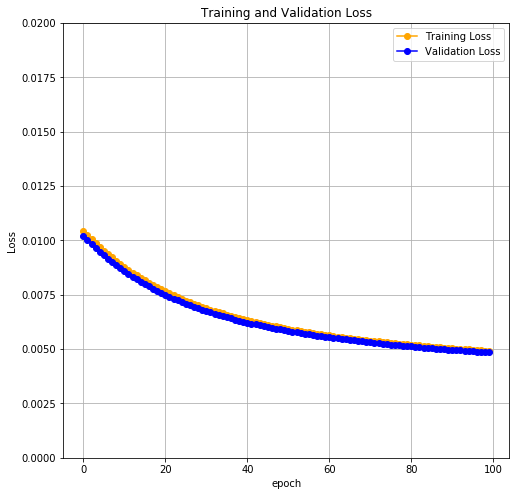

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="blue",)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,0.02])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()


MSE = 0.09188005602983192


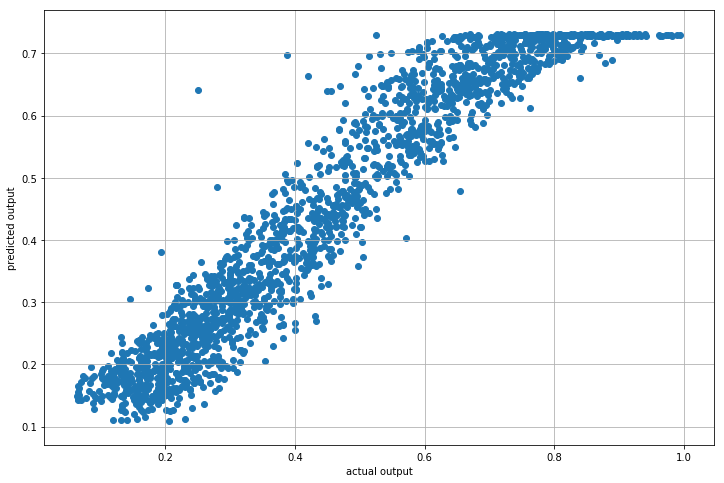

In [33]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred)
plt.xlabel('actual output')
plt.ylabel('predicted output')
plt.grid()

print('MSE =',(np.square(y_test - y_pred)).mean())

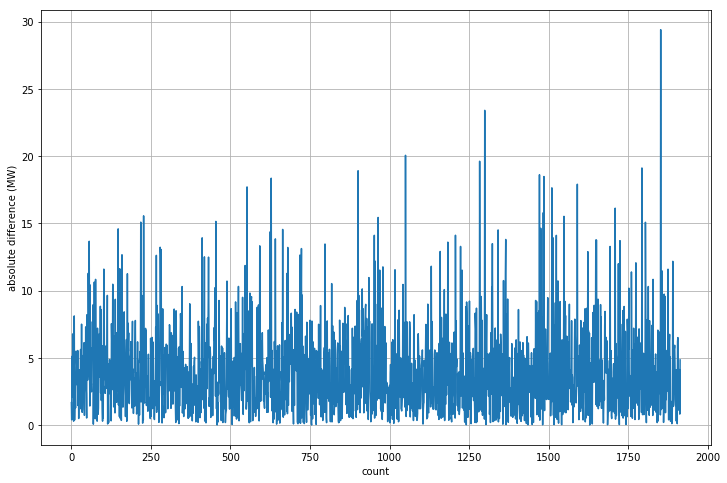

In [66]:
temp = np.append(X_test, y_pred, axis = 1)
PRED = scaler.inverse_transform(temp)

temp = np.append(X_test, np.reshape(y_test, (-1, 1)), axis = 1)
TEST = scaler.inverse_transform(temp)

diff = np.absolute(PRED[:,-1] - TEST[:,-1])

plt.figure(figsize=(12,8))
plt.plot(range(len(y_test)),diff)
plt.xlabel('count')
plt.ylabel('absolute difference (MW)')
plt.grid()

In [69]:
print('R2 score:', r2_score(y_test,y_pred))
# (coefficient of determination) regression score function.

R2 score: 0.908066025388397
